In [28]:
import os
os.getcwd()
import pandas as pd
import numpy as np
import datetime
import pandas_datareader
from pandas.tseries.offsets import *
import time
from scipy.stats import skew

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

id_wrds = ''

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# Load and preprocess CRSP data
crsp_raw = pd.read_pickle('/content/drive/MyDrive/crsp_raw.pkl')
crsp_clean = crsp_raw[crsp_raw['date'].dt.year >= 2010].copy()
crsp_clean['Year'] = crsp_clean['date'].dt.year
crsp_clean['Month'] = crsp_clean['date'].dt.month
crsp_clean = crsp_clean[['date', 'Year', 'Month', 'permno', 'naics', 'ret',  'prc', 'shrout']].dropna(subset=['naics'])
crsp_clean['NAICS_Sector'] = crsp_clean['naics'].astype(str).str[:2].astype(int)

# Define and map sectors
sector_data = {
    'NAICS_Sector': [11, 21, 22, 23, 31, 32, 33, 42, 44, 45, 48, 49, 51, 52, 53, 54, 55, 56, 61, 62, 71, 72, 81, 92],
    'Sector': ['Agriculture', 'Mining', 'Utilities', 'Construction', 'Manufacturing', 'Manufacturing', 'Manufacturing', 'Wholesale_Trade',
               'Retail_Trade', 'Retail_Trade', 'Transportation', 'Transportation', 'Information', 'Finance', 'Real_Estate', 'Professional_Services',
               'Management', 'Administrative', 'Education', 'Health', 'Arts', 'Accommodation', 'Other_Services', 'Public_Administration']
}
NAICS_Sector = pd.DataFrame(sector_data)

# Merge sector data with CRSP data
crsp_clean = crsp_clean.merge(NAICS_Sector, on='NAICS_Sector', how='left').dropna(subset=['Sector'])

# Create unique sector codes in the order they occur
sector_order = {sector: idx + 1 for idx, sector in enumerate(NAICS_Sector['Sector'].unique())}
crsp_clean['Code'] = crsp_clean['Sector'].map(sector_order)

# Filter for years up to 2023 and create 'YearMonth' column
crsp_clean = crsp_clean[crsp_clean['Year'] <= 2023].copy()
crsp_clean['YearMonth'] = (crsp_clean['Year'].astype(str) + crsp_clean['Month'].astype(str).str.zfill(2)).astype(int)

# Filter permnos with complete data from 2010.01 to 2023.12
valid_permnos = crsp_clean.groupby('permno')['YearMonth'].agg(['min', 'max'])
valid_permnos = valid_permnos[(valid_permnos['min'] <= 201001) & (valid_permnos['max'] >= 202312)].index
crsp_clean = crsp_clean[crsp_clean['permno'].isin(valid_permnos)]

# Remove records with changing sector codes
crsp_clean = crsp_clean.groupby('permno').filter(lambda x: x['NAICS_Sector'].nunique() == 1)

# Get sector statistics and filter by top 10 sectors
sector_stats = crsp_clean['Sector'].value_counts().nlargest(10).index
crsp_clean = crsp_clean[crsp_clean['Sector'].isin(sector_stats)]

crsp_clean['market_cap'] = np.abs(crsp_clean['prc'] * crsp_clean['shrout'])

# Determine top 500 stocks by average market capitalization over the entire period
avg_market_cap = crsp_clean.groupby('permno')['market_cap'].mean()
top_500_permnos = avg_market_cap.nlargest(500).index
crsp_clean = crsp_clean[crsp_clean['permno'].isin(top_500_permnos)]

# Save the cleaned data
crsp_clean.to_pickle('/content/drive/MyDrive/crsp_clean.pkl')


# Display the cleaned data
crsp_clean.head()

date  Year  Month  permno   naics       ret      prc     shrout  \
1262 2010-01-31  2010      1   10107  511210 -0.075459  28.1800  8770461.0   
1263 2010-02-28  2010      2   10107  511210  0.022001  28.6700  8770461.0   
1264 2010-03-31  2010      3   10107  511210  0.021538  29.2875  8762000.0   
1265 2010-04-30  2010      4   10107  511210  0.042595  30.5350  8763839.0   
1266 2010-05-31  2010      5   10107  511210 -0.150811  25.8000  8763839.0   

      NAICS_Sector       Sector  Code  YearMonth    market_cap  
1262            51  Information     9     201001  2.471516e+08  
1263            51  Information     9     201002  2.514491e+08  
1264            51  Information     9     201003  2.566171e+08  
1265            51  Information     9     201004  2.676038e+08  
1266            51  Information     9     201005  2.261070e+08

In [31]:
len(crsp_clean['permno'].unique())

500

#### Function for normal PCA to form correlation matrix

In [32]:
def PCA(df):
  # df should in following format:
  # permno - index for stocks
  # YearMonth - timestamp of return series
  # Sector - sector of stock
  # ret - return of stock

  # step 1: create pivot table
  df_pivot = df.pivot_table(index=['permno', 'Sector'], columns='YearMonth', values='ret', fill_value=0)

  # step 2: normalize return
  scaler = StandardScaler()
  standardized_data = scaler.fit_transform(df_pivot.T)
  df_pivot_standardized = pd.DataFrame(standardized_data, index=df_pivot.T.index, columns=df_pivot.T.columns).T

  # step 3: sort pivot table on Sector and permno
  df_pivot_standardized = df_pivot_standardized.sort_index(level=['Sector', 'permno'], ascending=[True, True])

  # step 4: correlation matrix
  correlation_matrix = df_pivot_standardized.T.corr()

  # step 5: fill in correlation matrix
  permno_list = df_pivot_standardized.index.get_level_values('permno')
  corr_matrix = pd.DataFrame(index=permno_list, columns=permno_list)
  corr_matrix.loc[permno_list, permno_list] = correlation_matrix.values

  corr_matrix = corr_matrix.apply(pd.to_numeric)

  return corr_matrix,df_pivot_standardized.index.get_level_values('Sector')

#### Function of Hierarchical PCA

In [33]:
def HPCA(df):
  # df should in following format:
  # permno - index for stocks
  # YearMonth - timestamp of return series
  # Sector - sector of stock
  # ret - return of stock

  # step 1: create pivot table
  df_pivot = df.pivot_table(index=['permno', 'Sector'], columns='YearMonth', values='ret', fill_value=0)

  # step 2: normalize return
  scaler = StandardScaler()
  standardized_data = scaler.fit_transform(df_pivot.T)
  df_pivot_standardized = pd.DataFrame(standardized_data, index=df_pivot.T.index, columns=df_pivot.T.columns).T

  # step 3: sort pivot table on Sector and permno
  df_pivot_standardized = df_pivot_standardized.sort_index(level=['Sector', 'permno'], ascending=[True, True])

  # step 4: HPCA
  # dictionary for data
  sector_eigvec = {}
  sector_eigval = {}
  sector_F_k = {}
  sector_corr = {}
  permno_beta = {}

  # unique_sector_list
  sector_list = df_pivot_standardized.index.get_level_values('Sector').unique()

  # for each sector, calculate correlation matrix, F_k, beta
  for sector in sector_list:
      # get sector data
      sector_data = df_pivot_standardized[df_pivot_standardized.index.get_level_values('Sector') == sector]
      # init PCA
      pca = PCA(n_components=1)
      # apply PCA and store results
      # PC1
      sector_eigvec[sector] = pca.fit_transform(sector_data)
      # lambda_1
      sector_eigval[sector] = pca.explained_variance_

      # permno list for the sector
      sector_permno_list = sector_data.index.get_level_values('permno')

      # 1/sqrt(lambda)
      lambda_k = sector_eigval[sector]
      temp2 = 1/np.sqrt(lambda_k)

      # eigvec portfolio
      F_k = sector_data.T@sector_eigvec[sector]

      # F_k
      sector_F_k[sector] = F_k.squeeze()*temp2

      # beta
      for index,permno in enumerate(sector_permno_list):
        X_series = np.array((sector_data.xs((permno, sector), level=('permno', 'Sector'), axis=0).reset_index(drop = True)).T.reset_index(drop = True))
        beta_i, _ = pearsonr(X_series.squeeze(), np.array(F_k).reshape(1,-1).T.squeeze())
        permno_beta[permno] = beta_i

      # corr matric within sector
      correlation_matrix = sector_data.T.corr()
      sector_corr[sector] = correlation_matrix

  # fill in the corr_matrix
  # permno list, which is the index of the matrix
  permno_list = df_pivot_standardized.index.get_level_values('permno')

  # get permno, sector pair
  sector_list = df_pivot_standardized.index.get_level_values('Sector')
  permno_sector_df = pd.DataFrame({
      'permno': permno_list,
      'Sector': sector_list
  })
  permno_sector = permno_sector_df.set_index('permno')['Sector'].to_dict()

  # init the corr_matrix
  corr_matrix = pd.DataFrame(index=permno_list, columns=permno_list)

  # Iterate over each sector and fill the corresponding sub-matrix
  for sector, permnos in permno_sector_df.groupby('Sector')['permno']:
      # Get the correlation matrix for this sector
      corr_matrix_input = sector_corr[sector]
      # fill in the values
      corr_matrix.loc[permnos, permnos] = corr_matrix_input.values

  # dic for rho values in sector
  sector_rho = {}

  # now fill the cross sector part
  for permno_i in permno_list:
    for permno_j in permno_list:
      # skip if there is already values
      if pd.isna(corr_matrix.at[permno_i, permno_j]):

        beta_i = permno_beta[permno_i]
        beta_j = permno_beta[permno_j]

        sector_i = permno_sector[permno_i]
        sector_j = permno_sector[permno_j]

        # calculate correlation between sectors
        # key to store rho
        uni_key = str(sector_i)+str(sector_j)
        # try if rho is avaliable
        rho = sector_rho.get(uni_key,np.nan)
        # if not calculated, calculate rho
        if np.isnan(rho):
          rho, _ = pearsonr(sector_F_k[sector_i], sector_F_k[sector_j])
          sector_rho[uni_key] = rho

        # calculate in value
        C_i_j = beta_i*beta_j*rho

        # fill it into 2 correspounding positions
        corr_matrix.at[permno_i, permno_j] = float(C_i_j)
        corr_matrix.at[permno_j, permno_i] = float(C_i_j)
        # print([beta_i,beta_j,rho])

  # Convert the filled values to numeric type
  corr_matrix = corr_matrix.apply(pd.to_numeric)

  return corr_matrix,df_pivot_standardized.index.get_level_values('Sector')


[*********************100%%**********************]  1 of 1 completed


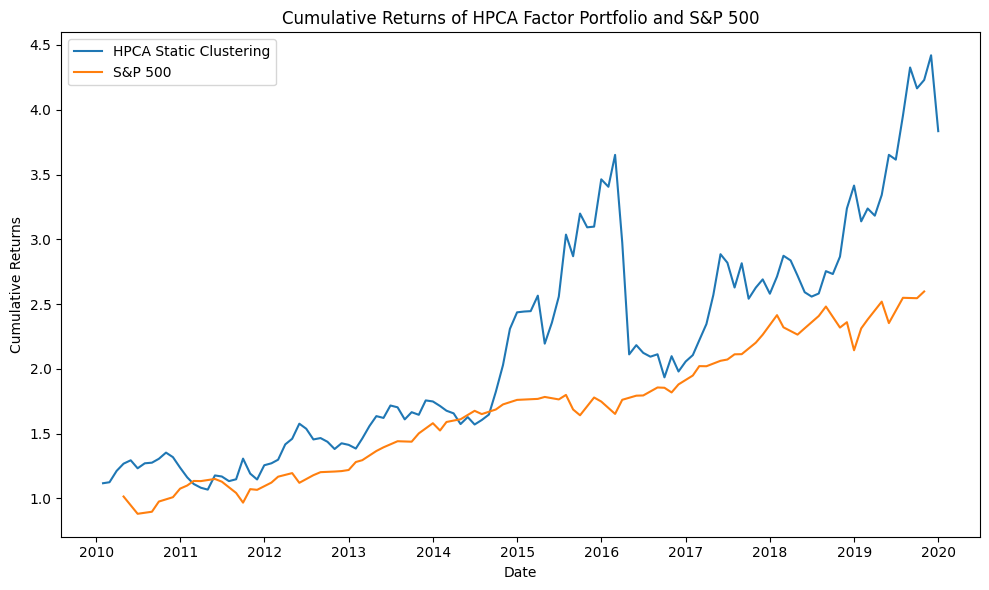

Annualized Mean  Volatility  Sharpe Ratio
HPCA Static Clustering         0.164135    0.237752      0.690361
S&P 500                        0.151379    0.147531      1.026083

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as SKPCA
from scipy.stats import pearsonr
from collections import defaultdict

# Function to apply PCA
def apply_pca(corr_matrix, n_components):
    pca = SKPCA(n_components=n_components)
    pca.fit(corr_matrix)
    return pca.explained_variance_ratio_

# HPCA function
def HPCA(df):
    df_pivot = df.pivot_table(index=['permno', 'Sector'], columns='YearMonth', values='ret', fill_value=0)
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df_pivot.T)
    df_pivot_standardized = pd.DataFrame(standardized_data, index=df_pivot.T.index, columns=df_pivot.T.columns).T
    df_pivot_standardized = df_pivot_standardized.sort_index(level=['Sector', 'permno'], ascending=[True, True])

    sector_eigvec = {}
    sector_eigval = {}
    sector_F_k = {}
    sector_corr = {}
    permno_beta = {}

    sector_list = df_pivot_standardized.index.get_level_values('Sector').unique()

    for sector in sector_list:
        sector_data = df_pivot_standardized[df_pivot_standardized.index.get_level_values('Sector') == sector]
        pca = SKPCA(n_components=1)
        sector_eigvec[sector] = pca.fit_transform(sector_data)
        sector_eigval[sector] = pca.explained_variance_
        sector_permno_list = sector_data.index.get_level_values('permno')
        lambda_k = sector_eigval[sector]
        temp2 = 1 / np.sqrt(lambda_k)
        F_k = sector_data.T @ sector_eigvec[sector]
        sector_F_k[sector] = F_k.squeeze() * temp2
        for index, permno in enumerate(sector_permno_list):
            X_series = np.array((sector_data.xs((permno, sector), level=('permno', 'Sector'), axis=0).reset_index(drop=True)).T.reset_index(drop=True))
            beta_i, _ = pearsonr(X_series.squeeze(), np.array(F_k).reshape(1, -1).T.squeeze())
            permno_beta[permno] = beta_i
        correlation_matrix = sector_data.T.corr()
        sector_corr[sector] = correlation_matrix

    permno_list = df_pivot_standardized.index.get_level_values('permno')
    sector_list = df_pivot_standardized.index.get_level_values('Sector')
    permno_sector_df = pd.DataFrame({'permno': permno_list, 'Sector': sector_list})
    permno_sector = permno_sector_df.set_index('permno')['Sector'].to_dict()

    corr_matrix = pd.DataFrame(index=permno_list, columns=permno_list)

    for sector, permnos in permno_sector_df.groupby('Sector')['permno']:
        corr_matrix_input = sector_corr[sector]
        permno_idx = [permno for permno in permnos if permno in corr_matrix.index]
        corr_matrix.loc[permno_idx, permno_idx] = corr_matrix_input.loc[permno_idx, permno_idx].values

    sector_rho = {}

    for permno_i in permno_list:
        for permno_j in permno_list:
            if pd.isna(corr_matrix.at[permno_i, permno_j]):
                beta_i = permno_beta[permno_i]
                beta_j = permno_beta[permno_j]
                sector_i = permno_sector[permno_i]
                sector_j = permno_sector[permno_j]
                uni_key = str(sector_i) + str(sector_j)
                rho = sector_rho.get(uni_key, np.nan)
                if np.isnan(rho):
                    rho, _ = pearsonr(sector_F_k[sector_i], sector_F_k[sector_j])
                    sector_rho[uni_key] = rho
                C_i_j = beta_i * beta_j * rho
                corr_matrix.at[permno_i, permno_j] = float(C_i_j)
                corr_matrix.at[permno_j, permno_i] = float(C_i_j)
    corr_matrix = corr_matrix.apply(pd.to_numeric)
    return corr_matrix, df_pivot_standardized.index.get_level_values('Sector')

# Apply HPCA
corr_matrix_hpca, _ = HPCA(crsp_clean)

# Calculate monthly returns for each cluster
monthly_returns = crsp_clean.groupby(['date', 'Sector'])['ret'].mean().reset_index()

# Pivot table to have clusters as columns
cluster_returns = monthly_returns.pivot_table(index='date', columns='Sector', values='ret')

# Calculate the Sharpe ratio for each cluster
annualized_mean_returns = cluster_returns.mean() * 12
annualized_volatility = cluster_returns.std() * np.sqrt(12)
sharpe_ratios = annualized_mean_returns / annualized_volatility

# Identify the clusters with the highest and lowest Sharpe ratios
highest_sharpe_cluster = sharpe_ratios.idxmax()
lowest_sharpe_cluster = sharpe_ratios.idxmin()

# Calculate the long-short portfolio returns
long_short_returns = cluster_returns[highest_sharpe_cluster] - cluster_returns[lowest_sharpe_cluster]
long_short_returns = long_short_returns[(long_short_returns.index >= '2010-01-01') & (long_short_returns.index <= '2019-12-31')]


# Calculate cumulative returns for the long-short portfolio
cumulative_long_short_returns = (1 + long_short_returns).cumprod()

# Download SPX data
# Download S&P 500 data from Yahoo Finance
sp500 = yf.download('^GSPC', start='2010-01-01', end='2019-12-31')

# Filter S&P 500 data to match dates in crsp_clean
sp500_filtered = sp500[sp500.index.isin(crsp_clean['date'].unique())]
sp500_filtered['ret'] = sp500_filtered['Adj Close'].pct_change()

# Calculate cumulative returns for S&P 500
cumulative_spx_returns = (1 + sp500_filtered['ret']).cumprod()

# Calculate the required metrics for the long-short portfolio and SPX
def calculate_metrics(returns):
    n_periods = len(returns)
    annualized_mean = returns.mean() * 12
    annualized_volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = annualized_mean / annualized_volatility
    return {
        "Annualized Mean": annualized_mean,
        "Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio
    }

metrics_long_short = calculate_metrics(long_short_returns)
metrics_spx = calculate_metrics(sp500_filtered['ret'])

# Plot cumulative returns for the long-short portfolio and SPX
plt.figure(figsize=(10, 6))
plt.plot(cumulative_long_short_returns, label='HPCA Static Clustering')
plt.plot(cumulative_spx_returns, label='S&P 500')
plt.title('Cumulative Returns of HPCA Factor Portfolio and S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.tight_layout()
plt.show()

# Display the calculated metrics
metrics_df = pd.DataFrame([metrics_long_short, metrics_spx], index=['HPCA Static Clustering', 'S&P 500'])
(metrics_df)

#### Function for plotting correlation matrix heatmap

In [35]:
def plot_corr_matrix(corr_matrix):
  plt.figure(figsize=(10, 8))
  plt.imshow(corr_matrix, cmap='RdBu', interpolation='nearest')
  plt.colorbar(label='Correlation')
  plt.title('Correlation Matrix Heatmap')
  plt.tight_layout()
  plt.show()

#### Function for applying PCA on correlation matrix and plotting PC(n)

In [36]:
def apply_pca(corr_matrix,n):
    pca = PCA(n_components=n)
    pca.fit(corr_matrix)
    return pca.components_

def plot_pcs(pcs,sector_list):
    plt.figure(figsize=(10, 20))
    for i, pc in enumerate(pcs, start=1):
        plt.subplot(len(pcs), 1, i)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.plot(np.arange(len(pc)), pc,linewidth = 0.5)
        plt.xticks(np.arange(len(pc)), sector_list, rotation=90, ha='right')
        plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=50))
        plt.tick_params(axis='x', labelsize=8)  # Adjust the font size as needed
        plt.title(f'PC{i}')
    plt.tight_layout()
    plt.show()


#### PCA correlation matrix

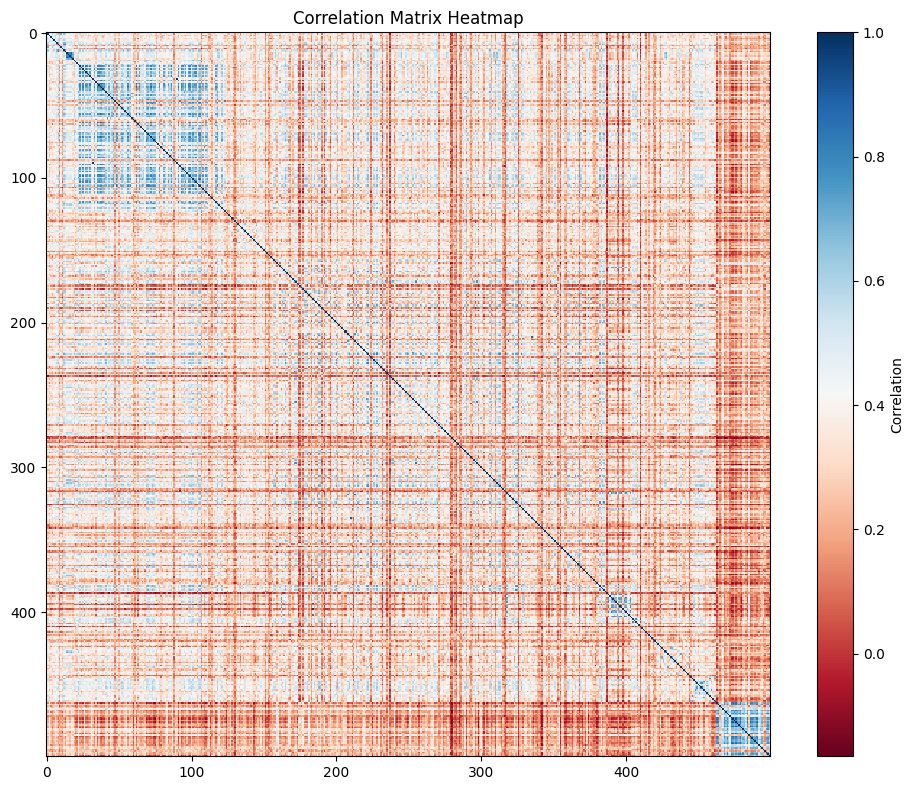

In [37]:
crsp_clean_HPCA = crsp_clean.copy()
corr_matrix_PCA,sector_list = PCA(crsp_clean_HPCA)
plot_corr_matrix(corr_matrix_PCA)

#### PCA PC analysis

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

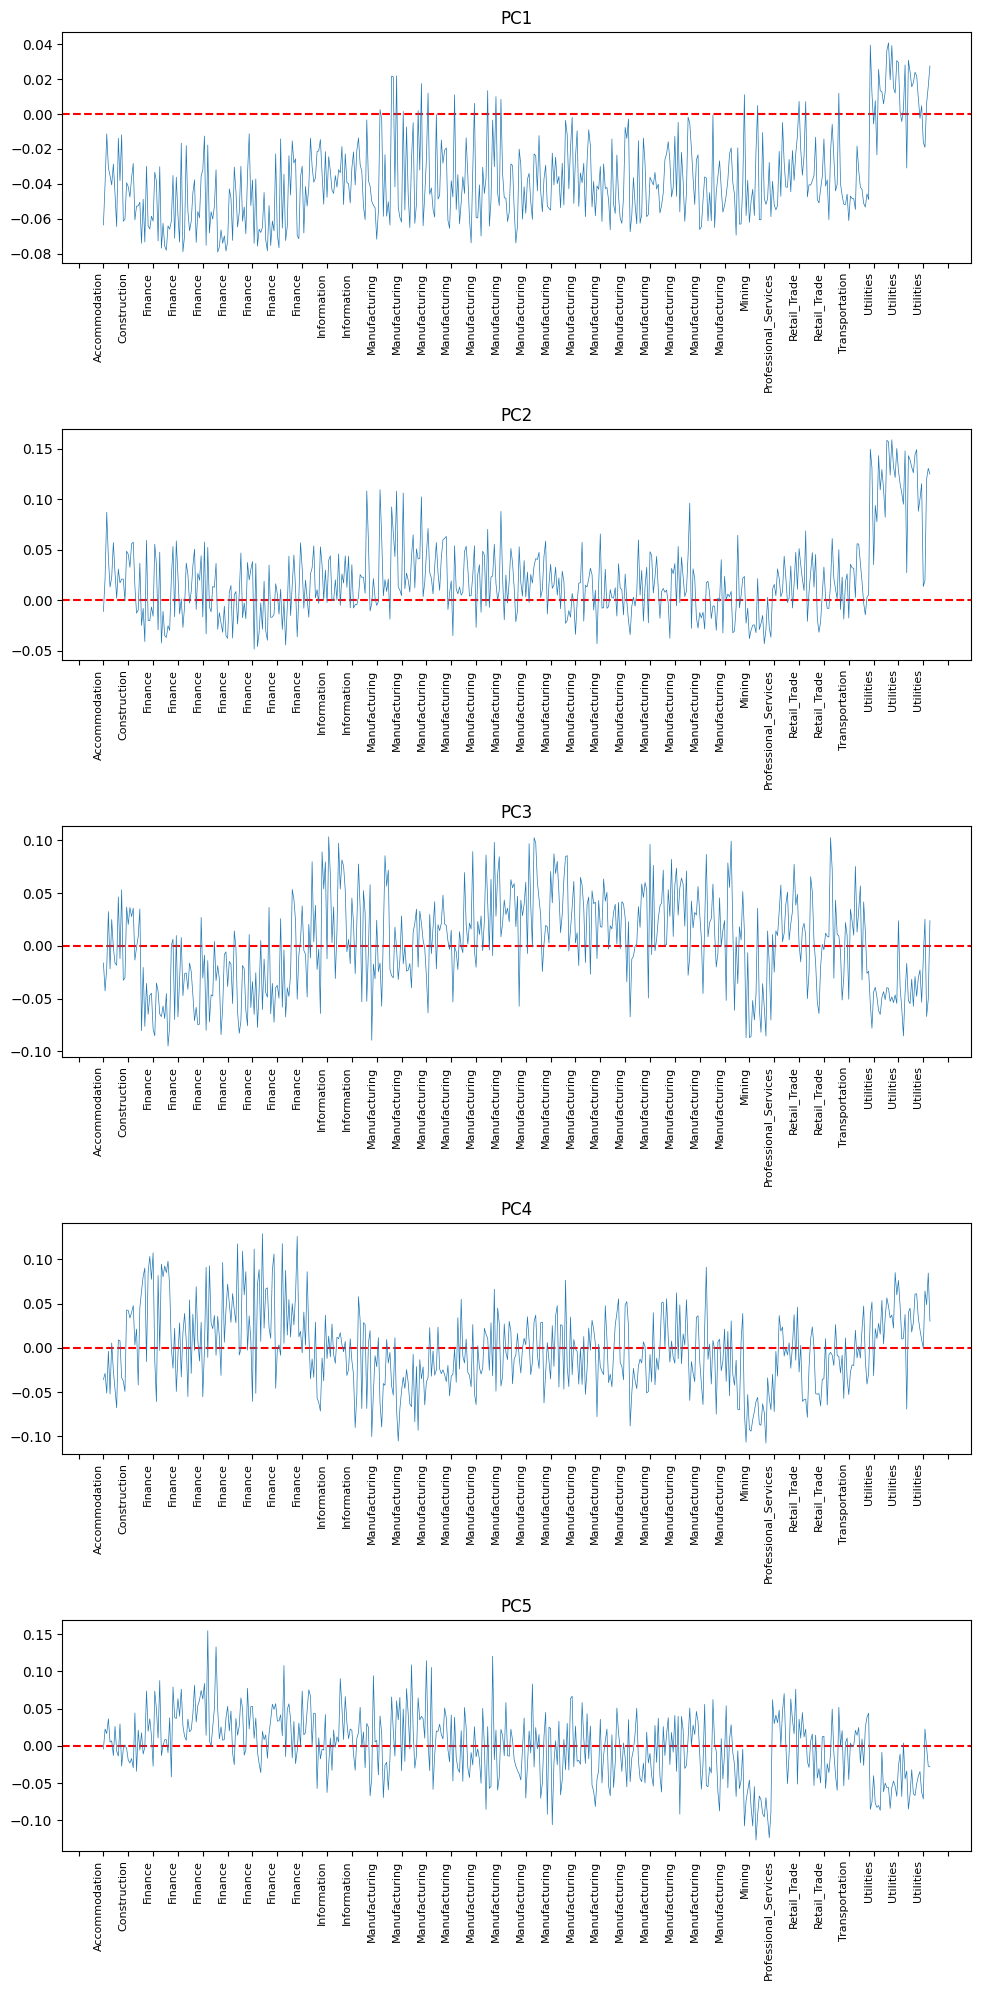

In [39]:
pcs_PCA= apply_pca(corr_matrix_PCA, 5)
plot_pcs(pcs_PCA,sector_list)

#### HPCA correlation matrix

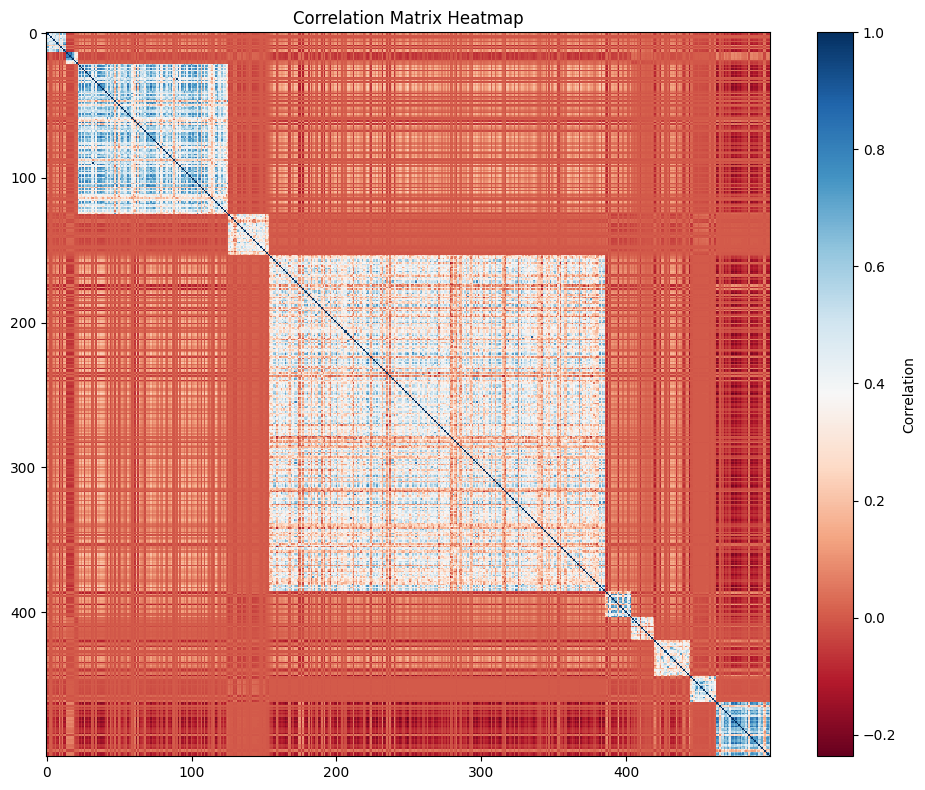

In [40]:
crsp_clean_HPCA = crsp_clean.copy()
corr_matrix_HPCA,sector_list = HPCA(crsp_clean_HPCA)
plot_corr_matrix(corr_matrix_HPCA)

#### NAICS sector clustering PC analysis

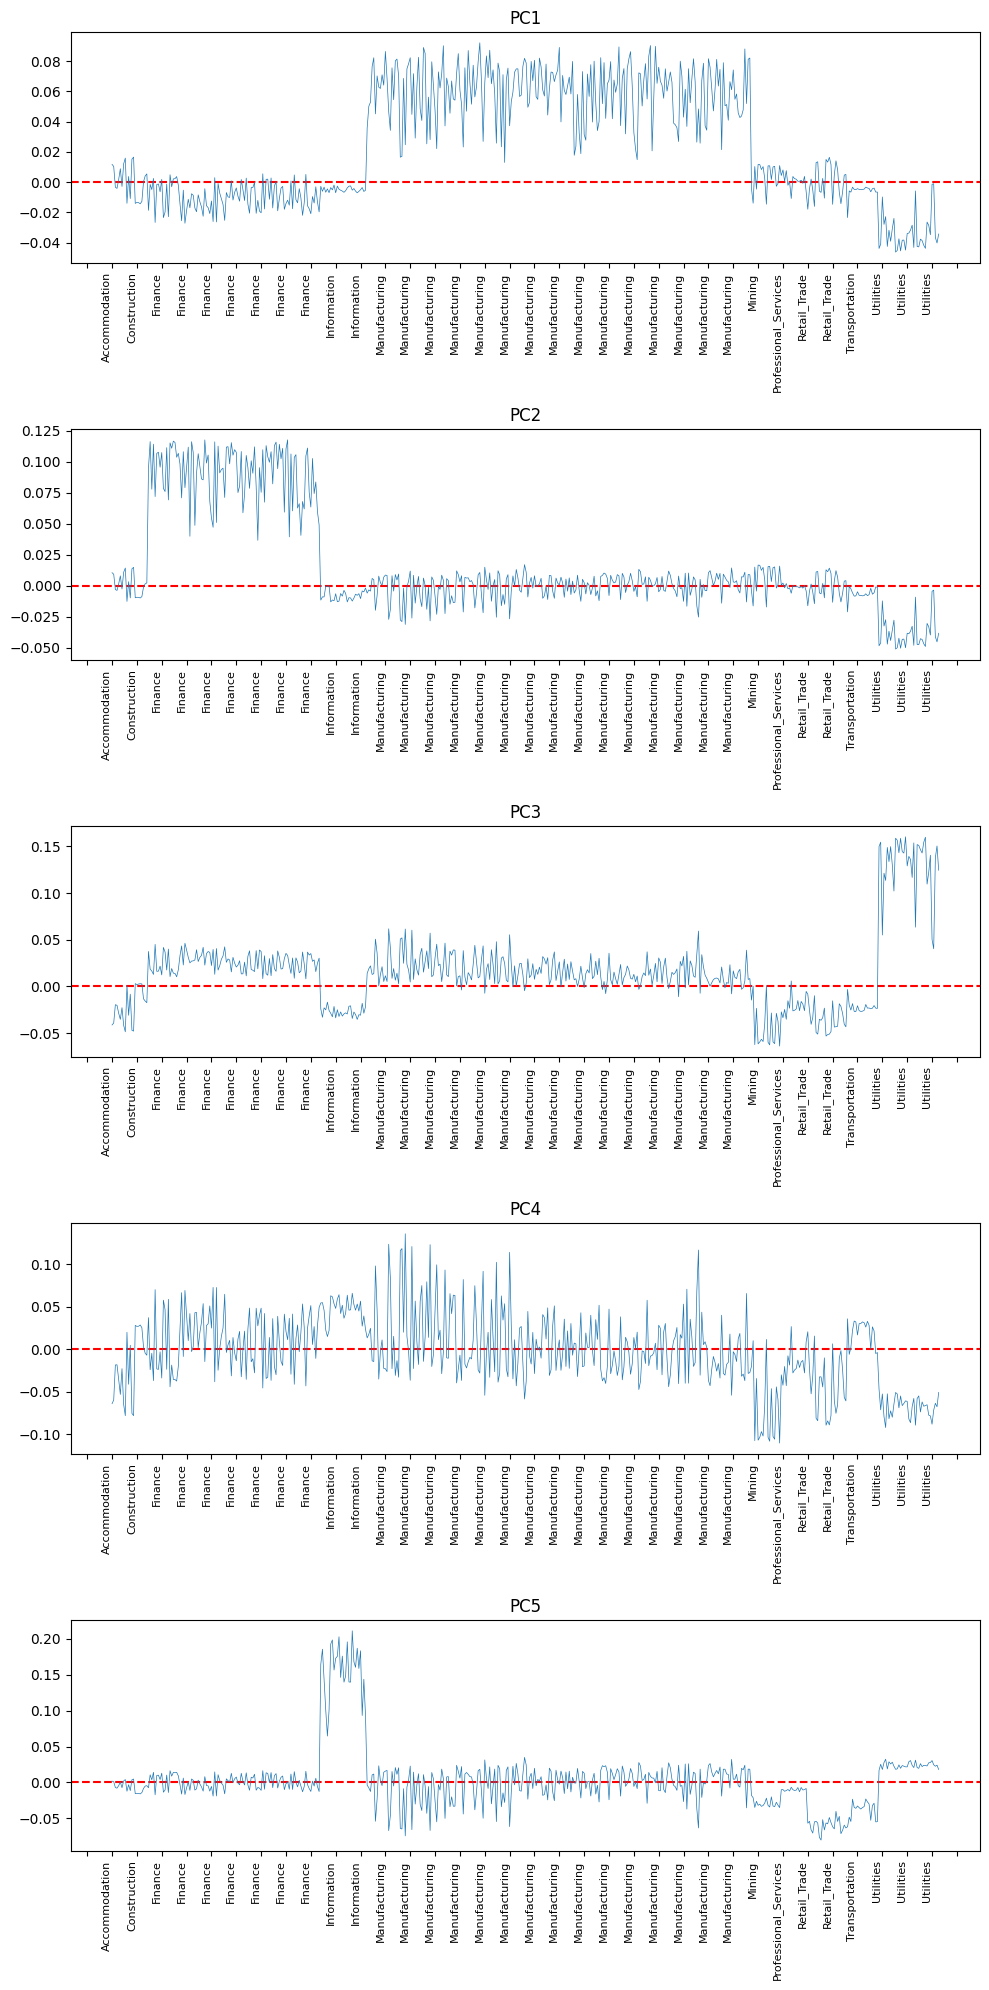

In [41]:
pcs_HPCA= apply_pca(corr_matrix_HPCA,5)
plot_pcs(pcs_HPCA,sector_list)

## Statistical Dynamic Clustering

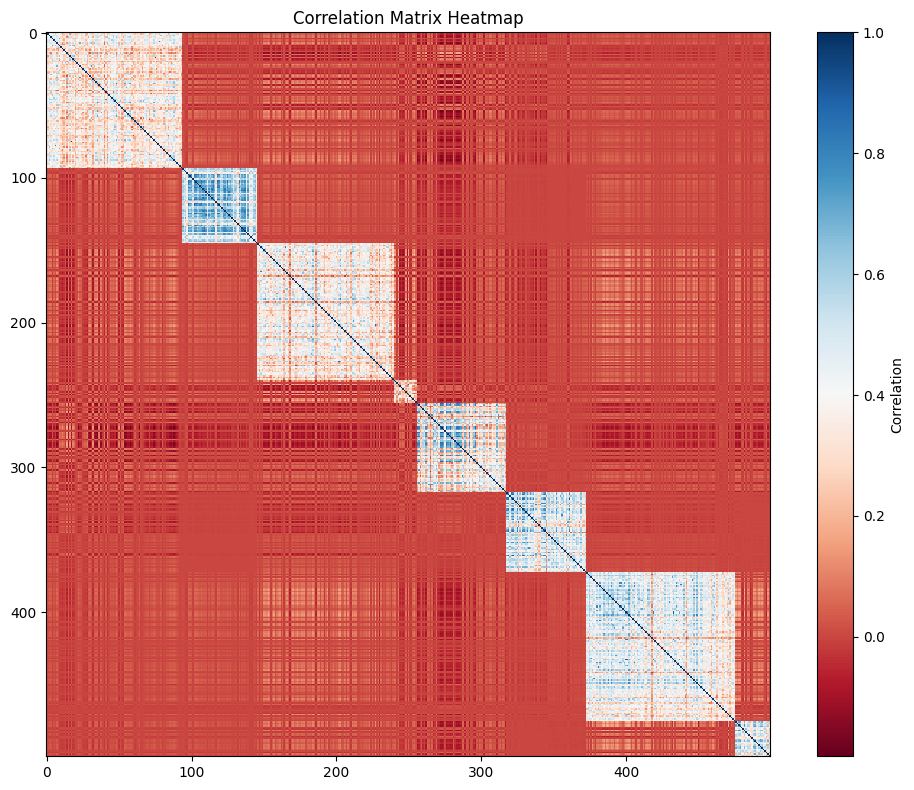

In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from collections import defaultdict

# Function to apply PCA
def apply_pca(corr_matrix, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(corr_matrix)
    return pca.components_

# Function to define clusters
def define_clusters(eigenvectors, n_clusters):
    # Omit the first eigenvector and use the next K-1 eigenvectors for clustering
    relevant_eigenvectors = eigenvectors[:, 1:n_clusters]

    # Determine the cluster for each stock based on the sign of the coefficients
    clusters = np.sign(relevant_eigenvectors)
    clusters = np.dot(clusters, 2**np.arange(clusters.shape[1]))  # Convert sign patterns to unique integers

    # Make sure cluster numbers are all positive
    min_cluster = np.min(clusters)
    if min_cluster < 0:
        clusters -= min_cluster - 1  # Shift clusters to make them all positive

    # Group stocks with the same sign pattern
    cluster_groups = defaultdict(list)
    for index, cluster in enumerate(clusters):
        cluster_groups[cluster].append(index)

    return cluster_groups

# Load and preprocess CRSP data
crsp_raw = pd.read_pickle('/content/drive/MyDrive/crsp_raw.pkl')
crsp_clean = crsp_raw[(crsp_raw['date'].dt.year >= 2010) & (crsp_raw['date'].dt.year <= 2023)].copy()
crsp_clean['Year'] = crsp_clean['date'].dt.year
crsp_clean['Month'] = crsp_clean['date'].dt.month
crsp_clean = crsp_clean[['date', 'Year', 'Month', 'permno', 'ret', 'prc', 'shrout', 'naics']].dropna()

# Define and map sectors
sector_data = {
    'NAICS_Sector': [11, 21, 22, 23, 31, 32, 33, 42, 44, 45, 48, 49, 51, 52, 53, 54, 55, 56, 61, 62, 71, 72, 81, 92],
    'Sector': ['Agriculture', 'Mining', 'Utilities', 'Construction', 'Manufacturing', 'Manufacturing', 'Manufacturing', 'Wholesale_Trade',
               'Retail_Trade', 'Retail_Trade', 'Transportation', 'Transportation', 'Information', 'Finance', 'Real_Estate', 'Professional_Services',
               'Management', 'Administrative', 'Education', 'Health', 'Arts', 'Accommodation', 'Other_Services', 'Public_Administration']
}
NAICS_Sector = pd.DataFrame(sector_data)

crsp_clean['NAICS_Sector'] = crsp_clean['naics'].astype(str).str[:2].astype(int)
crsp_clean = crsp_clean.merge(NAICS_Sector, on='NAICS_Sector', how='left').dropna(subset=['Sector'])

# Create unique sector codes in the order they occur
sector_order = {sector: idx + 1 for idx, sector in enumerate(NAICS_Sector['Sector'].unique())}
crsp_clean['Code'] = crsp_clean['Sector'].map(sector_order)

crsp_clean['YearMonth'] = (crsp_clean['Year'].astype(str) + crsp_clean['Month'].astype(str).str.zfill(2)).astype(int)
valid_permnos = crsp_clean.groupby('permno')['YearMonth'].agg(['min', 'max'])
valid_permnos = valid_permnos[(valid_permnos['min'] <= 201001) & (valid_permnos['max'] >= 202312)].index
crsp_clean = crsp_clean[crsp_clean['permno'].isin(valid_permnos)]

# Calculate market capitalization
crsp_clean['market_cap'] = np.abs(crsp_clean['prc'] * crsp_clean['shrout'])

# Determine top 500 stocks by average market capitalization over the entire period
avg_market_cap = crsp_clean.groupby('permno')['market_cap'].mean()
top_500_permnos = avg_market_cap.nlargest(500).index
crsp_clean = crsp_clean[crsp_clean['permno'].isin(top_500_permnos)]

# Create pivot table
df_pivot = crsp_clean.pivot_table(index=['permno'], columns='date', values='ret', fill_value=0)

# Normalize return
scaler = StandardScaler()
standardized_data = scaler.fit_transform(df_pivot.T)
df_pivot_standardized = pd.DataFrame(standardized_data, index=df_pivot.T.index, columns=df_pivot.T.columns).T

# Sort pivot table on permno
df_pivot_standardized = df_pivot_standardized.sort_index(level=['permno'], ascending=True)

# Correlation matrix
correlation_matrix = df_pivot_standardized.T.corr()

# Fill in correlation matrix
permno_list = df_pivot_standardized.index.get_level_values('permno')
corr_matrix = pd.DataFrame(index=permno_list, columns=permno_list)
corr_matrix.loc[permno_list, permno_list] = correlation_matrix.values

corr_matrix = corr_matrix.apply(pd.to_numeric)

# Apply PCA and define clusters
comp = apply_pca(corr_matrix, 4)
eigenvectors = comp.T
clusters = define_clusters(eigenvectors, len(eigenvectors))

# Map clusters to permnos
cluster_assignments = []
for cluster, indices in clusters.items():
    for index in indices:
        cluster_assignments.append((permno_list[index], cluster))

cluster_df = pd.DataFrame(cluster_assignments, columns=['permno', 'cluster'])

# Merge cluster information with crsp_clean
crsp_clean = crsp_clean.merge(cluster_df, on='permno')

# Pivot table with clusters
df_pivot = crsp_clean.pivot_table(index=['permno', 'cluster'], columns='date', values='ret', fill_value=0)

# Normalize return
standardized_data = scaler.fit_transform(df_pivot.T)
df_pivot_standardized = pd.DataFrame(standardized_data, index=df_pivot.T.index, columns=df_pivot.T.columns).T

# Sort pivot table on cluster and permno
df_pivot_standardized = df_pivot_standardized.sort_index(level=['cluster', 'permno'], ascending=[True, True])

# HPCA
# Dictionary for data
sector_eigvec = {}
sector_eigval = {}
sector_F_k = {}
sector_corr = {}
permno_beta = {}

# Unique cluster list
cluster_list = df_pivot_standardized.index.get_level_values('cluster').unique()

# For each cluster, calculate correlation matrix, F_k, beta
for c in cluster_list:
    # Get cluster data
    cluster_data = df_pivot_standardized[df_pivot_standardized.index.get_level_values('cluster') == c]
    # Init PCA
    pca = PCA(n_components=1)
    # Apply PCA and store results
    # PC1
    sector_eigvec[c] = pca.fit_transform(cluster_data)
    # lambda_1
    sector_eigval[c] = pca.explained_variance_

    # Permno list for the cluster
    cluster_permno_list = cluster_data.index.get_level_values('permno')

    # 1/sqrt(lambda)
    lambda_k = sector_eigval[c]
    temp2 = 1 / np.sqrt(lambda_k)

    # Eigvec portfolio
    F_k = cluster_data.T @ sector_eigvec[c]

    # F_k
    sector_F_k[c] = F_k.squeeze() * temp2

    # Beta
    for index, permno in enumerate(cluster_permno_list):
        X_series = np.array(cluster_data.xs((permno, c), level=('permno', 'cluster'), axis=0).reset_index(drop=True)).T
        beta_i, _ = pearsonr(X_series.squeeze(), np.array(F_k).reshape(1, -1).T.squeeze())
        permno_beta[permno] = beta_i

    # Correlation matrix within cluster
    correlation_matrix = cluster_data.T.corr()
    sector_corr[c] = correlation_matrix

# Fill in the corr_matrix
permno_list = df_pivot_standardized.index.get_level_values('permno')
sector_list = df_pivot_standardized.index.get_level_values('cluster')
permno_sector_df = pd.DataFrame({'permno': permno_list, 'cluster': sector_list})
permno_sector = permno_sector_df.set_index('permno')['cluster'].to_dict()

corr_matrix = pd.DataFrame(index=permno_list, columns=permno_list)

# Iterate over each cluster and fill the corresponding sub-matrix
for cluster, permnos in permno_sector_df.groupby('cluster')['permno']:
    corr_matrix_input = sector_corr[cluster]
    corr_matrix.loc[permnos, permnos] = corr_matrix_input.values

sector_rho = {}

# Fill the cross-cluster part
for permno_i in permno_list:
    for permno_j in permno_list:
        if pd.isna(corr_matrix.at[permno_i, permno_j]):
            beta_i = permno_beta[permno_i]
            beta_j = permno_beta[permno_j]

            cluster_i = permno_sector[permno_i]
            cluster_j = permno_sector[permno_j]

            uni_key = str(cluster_i) + str(cluster_j)
            rho = sector_rho.get(uni_key, np.nan)
            if np.isnan(rho):
                try:
                    rho, _ = pearsonr(sector_F_k[cluster_i], sector_F_k[cluster_j])
                except ValueError:
                    rho = 0
                sector_rho[uni_key] = rho

            C_i_j = beta_i * beta_j * rho
            corr_matrix.at[permno_i, permno_j] = float(C_i_j)
            corr_matrix.at[permno_j, permno_i] = float(C_i_j)

# Convert the filled values to numeric type
corr_matrix = corr_matrix.apply(pd.to_numeric)

corr_matrix
plot_corr_matrix(corr_matrix)

In [58]:
# Create DataFrame with different sectors in each cluster and additional information
sector_clusters = crsp_clean.groupby('cluster').agg(
    Sectors=('Sector', lambda x: list(x.unique())),
    Num_Sectors=('Sector', 'nunique'),
    Num_Stocks=('permno', 'nunique')
).reset_index()
sector_clusters

cluster                                            Sectors  Num_Sectors  \
0      1.0  [Manufacturing, Wholesale_Trade, Information, ...           13   
1      3.0  [Accommodation, Manufacturing, Transportation,...           10   
2      5.0  [Professional_Services, Information, Administr...           14   
3      7.0  [Manufacturing, Finance, Management, Professio...            7   
4      9.0  [Utilities, Retail_Trade, Manufacturing, Whole...           13   
5     11.0  [Manufacturing, Mining, Retail_Trade, Accommod...           15   
6     13.0  [Information, Professional_Services, Finance, ...           15   
7     15.0  [Manufacturing, Information, Retail_Trade, Adm...            8   

   Num_Stocks  
0          94  
1          52  
2          94  
3          16  
4          62  
5          55  
6         103  
7          24

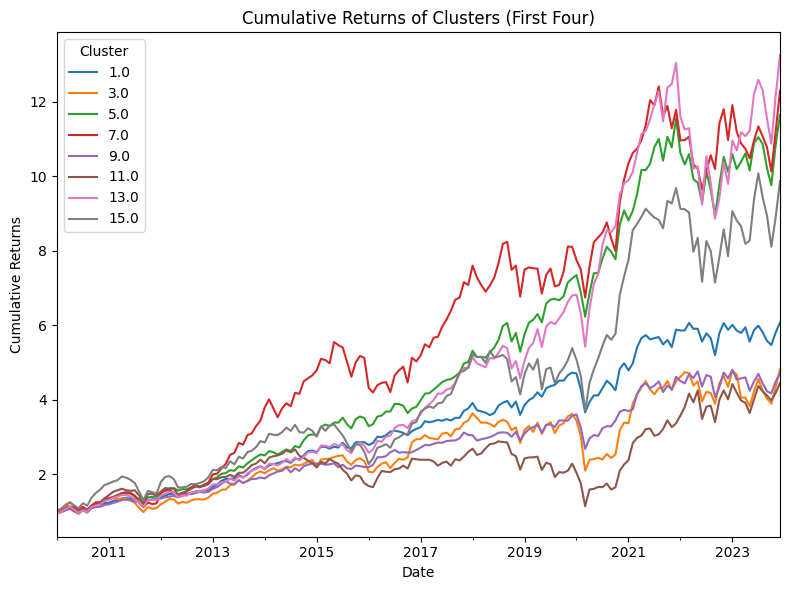

In [59]:
# Calculate monthly returns for each cluster
monthly_returns = crsp_clean.groupby(['date', 'cluster'])['ret'].mean().reset_index()

# Pivot table to have clusters as columns
cluster_returns = monthly_returns.pivot_table(index='date', columns='cluster', values='ret')

# Calculate cumulative returns
cumulative_returns = (1 + cluster_returns).cumprod()

# Plot cumulative returns for the first four clusters
cumulative_returns.iloc[:, :8].plot(figsize=(8, 6))
plt.title('Cumulative Returns of Clusters (First Four)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

13.0
11.0


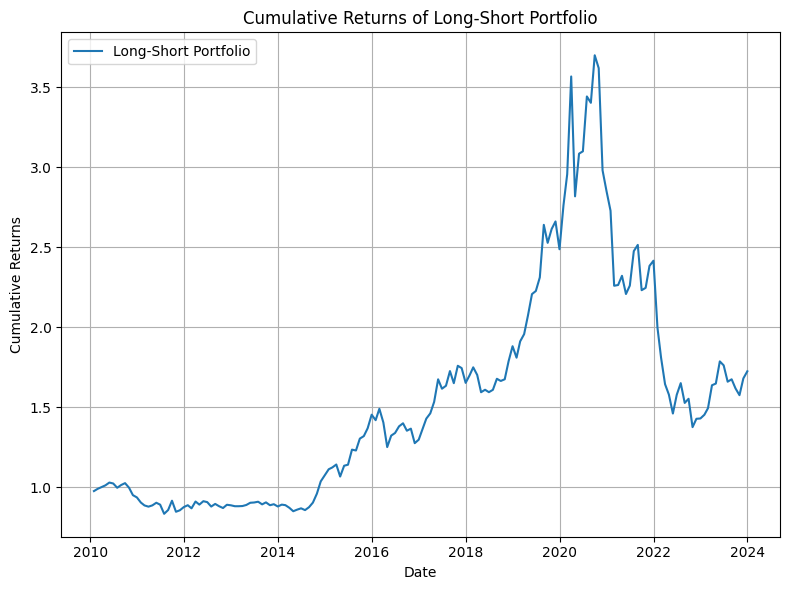

Annualized Mean  Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio
0         0.059752     0.19382      0.308284     -2.323809      0.025713

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Calculate monthly returns for each cluster
monthly_returns = crsp_clean.groupby(['date', 'cluster'])['ret'].mean().reset_index()

# Pivot table to have clusters as columns
cluster_returns = monthly_returns.pivot_table(index='date', columns='cluster', values='ret')

# Calculate cumulative returns
cumulative_returns = (1 + cluster_returns).cumprod()

# Identify the clusters with the highest and lowest cumulative returns
final_cumulative_returns = cumulative_returns.iloc[-1]
highest_cluster = final_cumulative_returns.idxmax()
print(highest_cluster)
lowest_cluster = final_cumulative_returns.idxmin()
print(lowest_cluster)

# Calculate the long-short portfolio returns
long_short_returns = cluster_returns[highest_cluster] - cluster_returns[lowest_cluster]

cumulative_long_short_returns = (1 + long_short_returns).cumprod()

# Calculate the required metrics
def calculate_metrics(returns):
    n_periods = len(returns)
    annualized_mean = (1 + returns.mean()) ** 12 - 1
    annualized_volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = annualized_mean / annualized_volatility

    # Calculate drawdown
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns - running_max
    max_drawdown = drawdown.min()

    # Calculate Calmar Ratio
    calmar_ratio = -annualized_mean / max_drawdown

    return {
        "Annualized Mean": annualized_mean,
        "Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }

metrics = calculate_metrics(long_short_returns)

# Plot cumulative returns for the long-short portfolio
plt.figure(figsize=(8, 6))
plt.plot(cumulative_long_short_returns, label='Long-Short Portfolio')
plt.title('Cumulative Returns of Long-Short Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the calculated metrics
metrics_df = pd.DataFrame([metrics])
metrics_df

[*********************100%%**********************]  1 of 1 completed


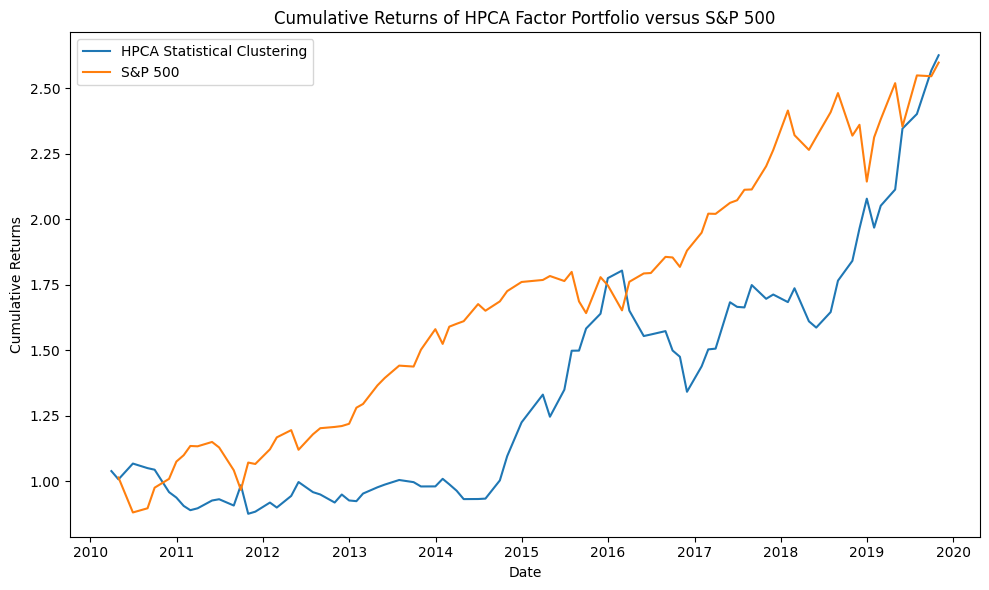

Annualized Mean  Volatility  Sharpe Ratio  \
HPCA Statistical Clustering         0.112885    0.149831      0.753415   
S&P 500                             0.162336    0.147531      1.100355   

                             Max Drawdown  Calmar Ratio  
HPCA Statistical Clustering     -0.268428      0.420542  
S&P 500                         -0.337489      0.481012

In [61]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Download S&P 500 data from Yahoo Finance
sp500 = yf.download('^GSPC', start='2010-01-01', end='2019-12-31')

# Filter S&P 500 data to match dates in crsp_clean
sp500_filtered = sp500[sp500.index.isin(crsp_clean['date'].unique())]
sp500_filtered['ret'] = sp500_filtered['Adj Close'].pct_change()

# Calculate cumulative returns for S&P 500
sp500_filtered['Cumulative Return'] = (1 + sp500_filtered['ret']).cumprod()

# Calculate monthly returns for each cluster
monthly_returns = crsp_clean.groupby(['date', 'cluster'])['ret'].mean().reset_index()

# Pivot table to have clusters as columns
cluster_returns = monthly_returns.pivot_table(index='date', columns='cluster', values='ret')

# Calculate cumulative returns
cumulative_returns = (1 + cluster_returns).cumprod()

# Identify the clusters with the highest and lowest cumulative returns
# final_cumulative_returns = cumulative_returns.iloc[-1]
# highest_cluster = final_cumulative_returns.idxmax()
# print(highest_cluster)
# lowest_cluster = final_cumulative_returns.idxmin()
# print(lowest_cluster)

# Calculate the Sharpe ratio for each cluster
annualized_mean_returns = cluster_returns.mean() * 12
annualized_volatility = cluster_returns.std() * np.sqrt(12)
sharpe_ratios = annualized_mean_returns / annualized_volatility

# Identify the clusters with the highest and lowest Sharpe ratios
highest_sharpe_cluster = sharpe_ratios.idxmax()
lowest_sharpe_cluster = sharpe_ratios.idxmin()

# Calculate the long-short portfolio returns
long_short_returns = cluster_returns[highest_sharpe_cluster] - cluster_returns[lowest_sharpe_cluster]
long_short_returns = long_short_returns[(long_short_returns.index >= '2010-01-01') & (long_short_returns.index <= '2019-12-31')]

# # Calculate the long-short portfolio returns
# long_short_returns = cluster_returns[highest_cluster] - cluster_returns[lowest_cluster]

# Calculate cumulative returns for the long-short portfolio
cumulative_long_short_returns = (1 + long_short_returns).cumprod()

# Align the dates in the cumulative returns of portfolios with the S&P 500 data
cumulative_long_short_returns = cumulative_long_short_returns.reindex(sp500_filtered.index).dropna()

# Calculate the required metrics
def calculate_metrics(returns):
    annualized_mean = (1 + returns.mean()) ** 12 - 1
    annualized_volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = annualized_mean / annualized_volatility

    # Calculate drawdown
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns - running_max
    max_drawdown = drawdown.min()

    # Calculate Calmar Ratio
    calmar_ratio = -annualized_mean / max_drawdown

    return {
        "Annualized Mean": annualized_mean,
        "Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }

metrics_long_short = calculate_metrics(long_short_returns.reindex(sp500_filtered.index).dropna())
metrics_sp500 = calculate_metrics(sp500_filtered['ret'])

# Plot cumulative returns for the long-short portfolio and S&P 500
plt.figure(figsize=(10, 6))
plt.plot(cumulative_long_short_returns, label='HPCA Statistical Clustering')
plt.plot(sp500_filtered['Cumulative Return'], label='S&P 500')
plt.title('Cumulative Returns of HPCA Factor Portfolio versus S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.tight_layout()
plt.show()

# Display the calculated metrics
metrics_df = pd.DataFrame([metrics_long_short, metrics_sp500], index=['HPCA Statistical Clustering', 'S&P 500'])
metrics_df

## K-Means Clustering

In [62]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [64]:
# Function to plot correlation matrix
def plot_corr_matrix(corr_matrix):
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='RdBu', interpolation='nearest')
    plt.colorbar(label='Correlation')
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()

# Function to apply PCA
def apply_pca(corr_matrix, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(corr_matrix)
    return pca.components_

# Function to compute eRank
def compute_erank(singular_values):
    P = singular_values / np.sum(singular_values)
    H = -np.sum(P * np.log(P))
    eRank = np.exp(H)
    return eRank

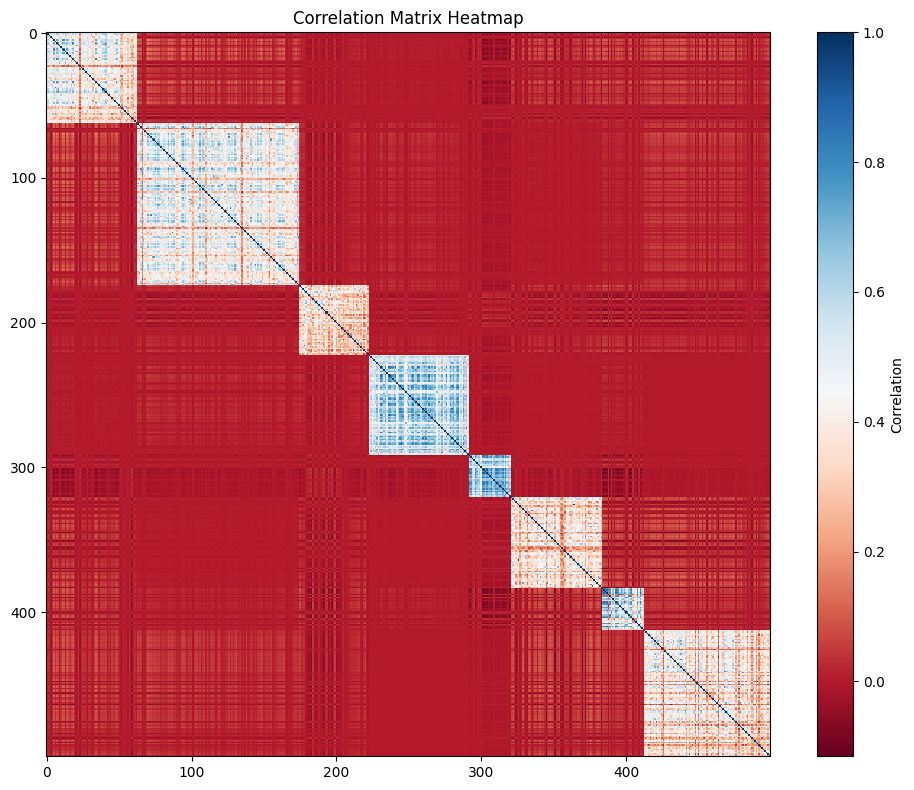

Effective Rank: 135.4313394889685


[*********************100%%**********************]  1 of 1 completed


In [65]:
# Load and preprocess CRSP data
crsp_raw = pd.read_pickle('/content/drive/MyDrive/crsp_raw.pkl')
crsp_clean = crsp_raw[(crsp_raw['date'].dt.year >= 2010) & (crsp_raw['date'].dt.year <= 2023)].copy()
crsp_clean['Year'] = crsp_clean['date'].dt.year
crsp_clean['Month'] = crsp_clean['date'].dt.month
crsp_clean = crsp_clean[['date', 'Year', 'Month', 'permno', 'ret', 'prc', 'shrout', 'naics']].dropna()

# Define and map sectors
sector_data = {
    'NAICS_Sector': [11, 21, 22, 23, 31, 32, 33, 42, 44, 45, 48, 49, 51, 52, 53, 54, 55, 56, 61, 62, 71, 72, 81, 92],
    'Sector': ['Agriculture', 'Mining', 'Utilities', 'Construction', 'Manufacturing', 'Manufacturing', 'Manufacturing', 'Wholesale_Trade',
               'Retail_Trade', 'Retail_Trade', 'Transportation', 'Transportation', 'Information', 'Finance', 'Real_Estate', 'Professional_Services',
               'Management', 'Administrative', 'Education', 'Health', 'Arts', 'Accommodation', 'Other_Services', 'Public_Administration']
}
NAICS_Sector = pd.DataFrame(sector_data)

crsp_clean['NAICS_Sector'] = crsp_clean['naics'].astype(str).str[:2].astype(int)
crsp_clean = crsp_clean.merge(NAICS_Sector, on='NAICS_Sector', how='left').dropna(subset=['Sector'])

# Create unique sector codes in the order they occur
sector_order = {sector: idx + 1 for idx, sector in enumerate(NAICS_Sector['Sector'].unique())}
crsp_clean['Code'] = crsp_clean['Sector'].map(sector_order)

crsp_clean['YearMonth'] = (crsp_clean['Year'].astype(str) + crsp_clean['Month'].astype(str).str.zfill(2)).astype(int)
valid_permnos = crsp_clean.groupby('permno')['YearMonth'].agg(['min', 'max'])
valid_permnos = valid_permnos[(valid_permnos['min'] <= 201001) & (valid_permnos['max'] >= 202312)].index
crsp_clean = crsp_clean[crsp_clean['permno'].isin(valid_permnos)]

# Calculate market capitalization
crsp_clean['market_cap'] = np.abs(crsp_clean['prc'] * crsp_clean['shrout'])

# Determine top 500 stocks by average market capitalization over the entire period
avg_market_cap = crsp_clean.groupby('permno')['market_cap'].mean()
top_500_permnos = avg_market_cap.nlargest(500).index
crsp_clean = crsp_clean[crsp_clean['permno'].isin(top_500_permnos)]

# Create pivot table
df_pivot = crsp_clean.pivot_table(index=['permno'], columns='date', values='ret', fill_value=0)

# Normalize returns
scaler = StandardScaler()
standardized_data = scaler.fit_transform(df_pivot.T)
df_pivot_standardized = pd.DataFrame(standardized_data, index=df_pivot.T.index, columns=df_pivot.T.columns).T

# Correlation matrix
correlation_matrix = df_pivot_standardized.T.corr()
permno_list = df_pivot_standardized.index.get_level_values('permno')
corr_matrix = pd.DataFrame(index=permno_list, columns=permno_list)
corr_matrix.loc[permno_list, permno_list] = correlation_matrix.values
corr_matrix = corr_matrix.apply(pd.to_numeric)

# Apply PCA
n_pca_components = 4
comp = apply_pca(corr_matrix, n_pca_components)
pca_components = comp.T

# Apply K-means clustering
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(pca_components)

# Assign clusters to permnos
cluster_assignments = kmeans.labels_
cluster_df = pd.DataFrame({'permno': permno_list, 'cluster': cluster_assignments})

# Merge cluster information with crsp_clean
crsp_clean = crsp_clean.merge(cluster_df, on='permno')

# Pivot table with clusters
df_pivot = crsp_clean.pivot_table(index=['permno', 'cluster'], columns='date', values='ret', fill_value=0)

# Normalize returns
standardized_data = scaler.fit_transform(df_pivot.T)
df_pivot_standardized = pd.DataFrame(standardized_data, index=df_pivot.T.index, columns=df_pivot.T.columns).T

# Sort pivot table on cluster and permno
df_pivot_standardized = df_pivot_standardized.sort_index(level=['cluster', 'permno'], ascending=[True, True])

# HPCA
sector_eigvec = {}
sector_eigval = {}
sector_F_k = {}
sector_corr = {}
permno_beta = {}

cluster_list = df_pivot_standardized.index.get_level_values('cluster').unique()

for c in cluster_list:
    cluster_data = df_pivot_standardized[df_pivot_standardized.index.get_level_values('cluster') == c]
    pca = PCA(n_components=1)
    sector_eigvec[c] = pca.fit_transform(cluster_data)
    sector_eigval[c] = pca.explained_variance_
    cluster_permno_list = cluster_data.index.get_level_values('permno')
    lambda_k = sector_eigval[c]
    temp2 = 1 / np.sqrt(lambda_k)
    F_k = cluster_data.T @ sector_eigvec[c]
    sector_F_k[c] = F_k.squeeze() * temp2
    for index, permno in enumerate(cluster_permno_list):
        X_series = np.array(cluster_data.xs((permno, c), level=('permno', 'cluster'), axis=0).reset_index(drop=True)).T
        beta_i, _ = pearsonr(X_series.squeeze(), np.array(F_k).reshape(1, -1).T.squeeze())
        permno_beta[permno] = beta_i
    correlation_matrix = cluster_data.T.corr()
    sector_corr[c] = correlation_matrix

permno_list = df_pivot_standardized.index.get_level_values('permno')
sector_list = df_pivot_standardized.index.get_level_values('cluster')
permno_sector_df = pd.DataFrame({'permno': permno_list, 'cluster': sector_list})
permno_sector = permno_sector_df.set_index('permno')['cluster'].to_dict()

corr_matrix = pd.DataFrame(index=permno_list, columns=permno_list)

for cluster, permnos in permno_sector_df.groupby('cluster')['permno']:
    corr_matrix_input = sector_corr[cluster]
    corr_matrix.loc[permnos, permnos] = corr_matrix_input.values

sector_rho = {}

for permno_i in permno_list:
    for permno_j in permno_list:
        if pd.isna(corr_matrix.at[permno_i, permno_j]):
            beta_i = permno_beta[permno_i]
            beta_j = permno_beta[permno_j]
            cluster_i = permno_sector[permno_i]
            cluster_j = permno_sector[permno_j]
            uni_key = str(cluster_i) + str(cluster_j)
            rho = sector_rho.get(uni_key, np.nan)
            if np.isnan(rho):
                try:
                    rho, _ = pearsonr(sector_F_k[cluster_i], sector_F_k[cluster_j])
                except ValueError:
                    rho = 0
                sector_rho[uni_key] = rho
            C_i_j = beta_i * beta_j * rho
            corr_matrix.at[permno_i, permno_j] = float(C_i_j)
            corr_matrix.at[permno_j, permno_i] = float(C_i_j)

corr_matrix = corr_matrix.apply(pd.to_numeric)

plot_corr_matrix(corr_matrix)

# Calculate the eRank
U, s, Vt = np.linalg.svd(df_pivot_standardized.T, full_matrices=False)
eRank = compute_erank(s)
print(f'Effective Rank: {eRank}')

# Select the number of components based on eRank (rounded to the nearest integer)
n_components = int(round(eRank))

# Reconstruct correlation matrix using the selected number of components
reconstructed_correlation_matrix = np.dot(U[:, :n_components] * s[:n_components], Vt[:n_components, :])

# Calculate the factor loadings
factor_loadings = U[:, :n_components]

# Calculate expected returns
expected_returns = np.dot(factor_loadings, np.dot(np.diag(s[:n_components]), Vt[:n_components, :]))

# Convert expected returns to DataFrame
expected_returns_df = pd.DataFrame(expected_returns.T, index=df_pivot_standardized.index, columns=df_pivot_standardized.columns)

# Calculate weights based on market capitalization
crsp_clean['weight'] = crsp_clean.groupby(['date', 'cluster'])['market_cap'].transform(lambda x: x / x.sum())

# Calculate value-weighted returns for each portfolio
value_weighted_returns = crsp_clean.groupby(['date', 'cluster']).apply(lambda x: (x['ret'] * x['weight']).sum()).reset_index()
value_weighted_returns = value_weighted_returns.rename(columns={0: 'vw_ret'})

# Pivot table to have portfolios as columns
portfolio_returns = value_weighted_returns.pivot_table(index='date', columns='cluster', values='vw_ret')

# Download S&P 500 data from Yahoo Finance
sp500 = yf.download('^GSPC', start='2010-01-01', end='2023-12-31')

# Filter S&P 500 data to match dates in crsp_clean
sp500_filtered = sp500[sp500.index.isin(crsp_clean['date'].unique())]
sp500_filtered['ret'] = sp500_filtered['Adj Close'].pct_change()

# Calculate cumulative returns for S&P 500
sp500_filtered['Cumulative Return'] = (1 + sp500_filtered['ret']).cumprod()

# Calculate cumulative returns for the portfolios
cumulative_returns = (1 + portfolio_returns).cumprod()

# Align the dates in the cumulative returns of portfolios with the S&P 500 data
cumulative_returns = cumulative_returns.reindex(sp500_filtered.index).dropna()

In [66]:
# Function to calculate Annualized Mean for monthly data
def calculate_annualized_mean(returns):
    return returns.mean() * 12  # 12 months in a year

# Function to calculate Annualized Volatility for monthly data
def calculate_annualized_vol(returns):
    return returns.std() * np.sqrt(12)  # 12 months in a year

# Function to calculate Sharpe Ratio for monthly data (assuming risk-free rate is 0)
def calculate_sharpe_ratio(returns):
    return returns.mean() / returns.std() * np.sqrt(12)  # 12 months in a year

# Function to calculate Maximum Drawdown
def calculate_max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - roll_max) / roll_max
    return drawdown.min()

# Function to calculate Calmar Ratio
def calculate_calmar_ratio(annualized_mean, max_drawdown):
    return annualized_mean / abs(max_drawdown)

# Calculate metrics for each cluster and the S&P 500
metrics = {}

# Calculate metrics for each cluster
for col in cumulative_returns.columns:
    cluster_returns = cumulative_returns[col].pct_change().dropna()
    annualized_mean = calculate_annualized_mean(cluster_returns)
    annualized_vol = calculate_annualized_vol(cluster_returns)
    sharpe_ratio = calculate_sharpe_ratio(cluster_returns)
    max_drawdown = calculate_max_drawdown(cumulative_returns[col])
    calmar_ratio = calculate_calmar_ratio(annualized_mean, max_drawdown)

    metrics[col] = {
        'Annualized Mean': annualized_mean,
        'Annualized Vol': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio
    }

# Add S&P 500 metrics
sp500_filtered['Cumulative Return'] = (1 + sp500_filtered['ret']).cumprod()
annualized_mean_sp500 = calculate_annualized_mean(sp500_filtered['ret'].dropna())
annualized_vol_sp500 = calculate_annualized_vol(sp500_filtered['ret'].dropna())
sharpe_ratio_sp500 = calculate_sharpe_ratio(sp500_filtered['ret'].dropna())
max_drawdown_sp500 = calculate_max_drawdown(sp500_filtered['Cumulative Return'])
calmar_ratio_sp500 = calculate_calmar_ratio(annualized_mean_sp500, max_drawdown_sp500)

metrics['S&P 500'] = {
    'Annualized Mean': annualized_mean_sp500,
    'Annualized Vol': annualized_vol_sp500,
    'Sharpe Ratio': sharpe_ratio_sp500,
    'Max Drawdown': max_drawdown_sp500,
    'Calmar Ratio': calmar_ratio_sp500
}

# Convert metrics to DataFrame for better readability
metrics_df = pd.DataFrame(metrics).T
metrics_df

Annualized Mean  Annualized Vol  Sharpe Ratio  Max Drawdown  \
0               0.360544        0.231299      1.558774     -0.305408   
1               0.226718        0.222644      1.018300     -0.281185   
2               0.171344        0.133418      1.284265     -0.127691   
3               0.186978        0.272549      0.686035     -0.389410   
4               0.160340        0.170435      0.940765     -0.184434   
5               0.231747        0.160168      1.446894     -0.181038   
6               0.197780        0.311181      0.635579     -0.480730   
7               0.283511        0.180610      1.569740     -0.241624   
S&P 500         0.156270        0.175682      0.889503     -0.247695   

         Calmar Ratio  
0            1.180532  
1            0.806297  
2            1.341863  
3            0.480158  
4            0.869358  
5            1.280098  
6            0.411416  
7            1.173353  
S&P 500      0.630894

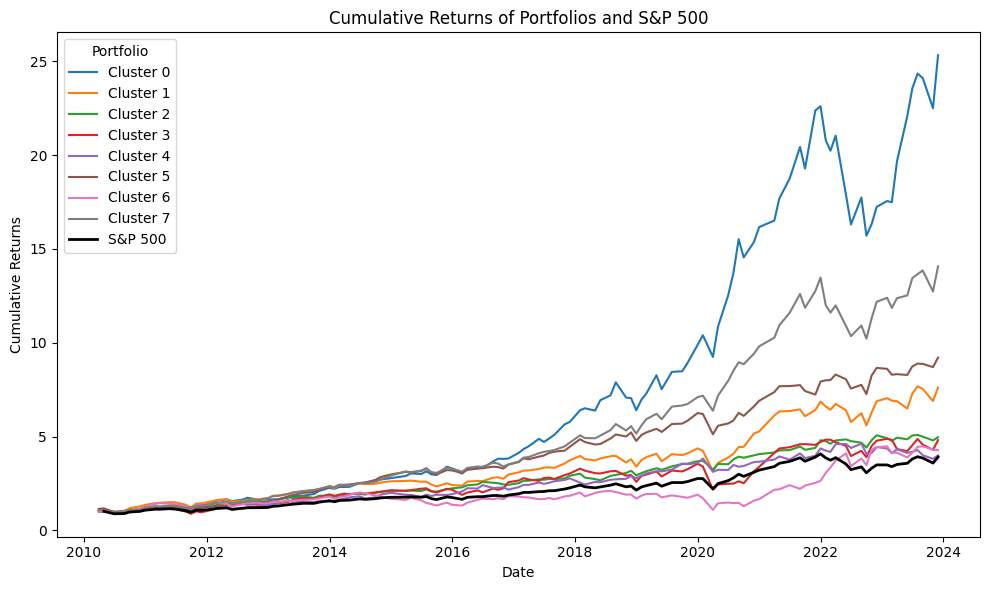

In [67]:
# Plot cumulative returns
plt.figure(figsize=(10, 6))
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=f'Cluster {col}')
plt.plot(sp500_filtered.index, sp500_filtered['Cumulative Return'], label='S&P 500', color='black', linewidth=2)
plt.title('Cumulative Returns of Portfolios and S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(title='Portfolio')
plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed


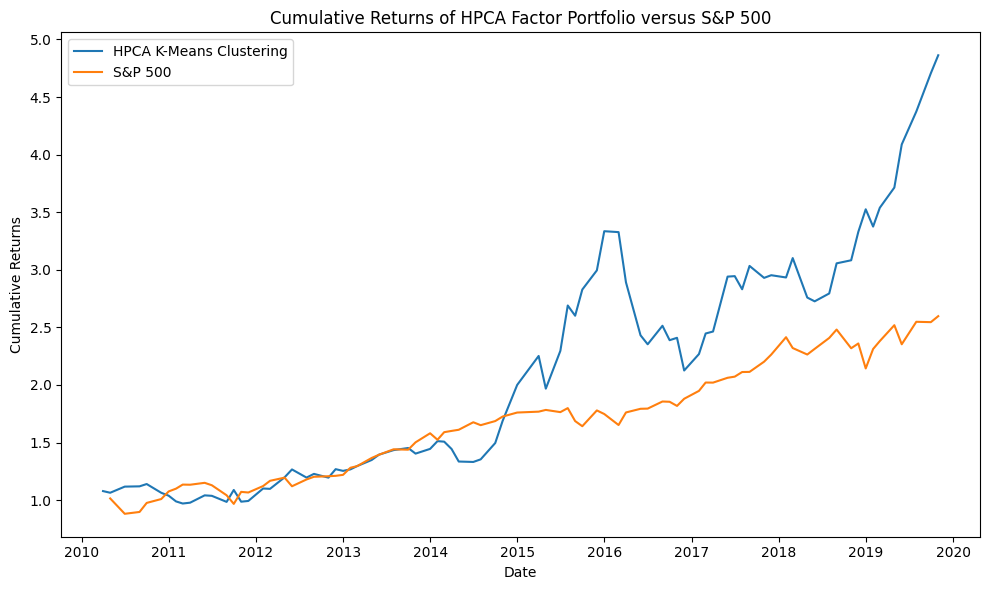

Annualized Mean  Volatility  Sharpe Ratio  \
HPCA K-Means Clustering         0.223469    0.196427      1.137673   
S&P 500                         0.162336    0.147531      1.100355   

                         Max Drawdown  Calmar Ratio  
HPCA K-Means Clustering     -0.493911      0.452449  
S&P 500                     -0.337489      0.481012

In [68]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Download S&P 500 data from Yahoo Finance
sp500 = yf.download('^GSPC', start='2010-01-01', end='2019-12-31')

# Filter S&P 500 data to match dates in crsp_clean
sp500_filtered = sp500[sp500.index.isin(crsp_clean['date'].unique())]
sp500_filtered['ret'] = sp500_filtered['Adj Close'].pct_change()

# Calculate cumulative returns for S&P 500
sp500_filtered['Cumulative Return'] = (1 + sp500_filtered['ret']).cumprod()

# Calculate monthly returns for each cluster
monthly_returns = crsp_clean.groupby(['date', 'cluster'])['ret'].mean().reset_index()

# Pivot table to have clusters as columns
cluster_returns = monthly_returns.pivot_table(index='date', columns='cluster', values='ret')

# Calculate the Sharpe ratio for each cluster
annualized_mean_returns = cluster_returns.mean() * 12
annualized_volatility = cluster_returns.std() * np.sqrt(12)
sharpe_ratios = annualized_mean_returns / annualized_volatility

# Identify the clusters with the highest and lowest Sharpe ratios
highest_sharpe_cluster = sharpe_ratios.idxmax()
lowest_sharpe_cluster = sharpe_ratios.idxmin()

# Calculate the long-short portfolio returns
long_short_returns = cluster_returns[highest_sharpe_cluster] - cluster_returns[lowest_sharpe_cluster]
long_short_returns = long_short_returns[(long_short_returns.index >= '2010-01-01') & (long_short_returns.index <= '2019-12-31')]

# Calculate cumulative returns for the long-short portfolio
cumulative_long_short_returns = (1 + long_short_returns).cumprod()

# Align the dates in the cumulative returns of the long-short portfolio with the S&P 500 data
cumulative_long_short_returns = cumulative_long_short_returns.reindex(sp500_filtered.index).dropna()

# Calculate the required metrics
def calculate_metrics(returns):
    annualized_mean = (1 + returns.mean()) ** 12 - 1
    annualized_volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = annualized_mean / annualized_volatility

    # Calculate drawdown
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns - running_max
    max_drawdown = drawdown.min()

    # Calculate Calmar Ratio
    calmar_ratio = -annualized_mean / max_drawdown

    return {
        "Annualized Mean": annualized_mean,
        "Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }

metrics_long_short = calculate_metrics(long_short_returns.reindex(sp500_filtered.index).dropna())
metrics_sp500 = calculate_metrics(sp500_filtered['ret'])

# Plot cumulative returns for the long-short portfolio and S&P 500
plt.figure(figsize=(10, 6))
plt.plot(cumulative_long_short_returns, label='HPCA K-Means Clustering')
plt.plot(sp500_filtered['Cumulative Return'], label='S&P 500')
plt.title('Cumulative Returns of HPCA Factor Portfolio versus S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.tight_layout()
plt.show()

# Display the calculated metrics
metrics_df = pd.DataFrame([metrics_long_short, metrics_sp500], index=['HPCA K-Means Clustering', 'S&P 500'])
metrics_df

In [69]:
# Create DataFrame with different sectors in each cluster
sector_clusters = crsp_clean.groupby('cluster').agg(
    Sectors=('Sector', lambda x: list(x.unique())),
    Num_Sectors=('Sector', 'nunique'),
    Num_Stocks=('permno', 'nunique')
).reset_index()
sector_clusters

cluster                                            Sectors  Num_Sectors  \
0        0  [Information, Finance, Professional_Services, ...           15   
1        1  [Retail_Trade, Wholesale_Trade, Manufacturing,...           17   
2        2  [Finance, Manufacturing, Administrative, Retai...            8   
3        3  [Manufacturing, Accommodation, Real_Estate, Wh...           11   
4        4  [Utilities, Professional_Services, Constructio...            4   
5        5  [Manufacturing, Wholesale_Trade, Information, ...           12   
6        6  [Manufacturing, Mining, Retail_Trade, Utilitie...            8   
7        7  [Information, Professional_Services, Administr...           14   

   Num_Stocks  
0          63  
1         112  
2          48  
3          69  
4          29  
5          63  
6          29  
7          87